## 7. Nonlinear ensemble filtering for the Lorenz-96 problem

In this notebook, we apply the stochastic map filter developed in Spantini et al. [5] to the Lorenz-96 problem.

References: 

[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `TransportMapBasedInference`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [1]:
using Revise
using LinearAlgebra
using TransportBasedInference
using Statistics
using Distributions
using OrdinaryDiffEq

In [2]:
using DelimitedFiles

Load some packages to make nice figures

In [3]:
using Plots
default(tickfont = font("CMU Serif", 14), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 14),
        legendfont = font("CMU Serif", 14),
        grid = false)
pyplot()

using ColorSchemes
using LaTeXStrings

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [4]:
Nx = 40
Ny = 20

20

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [5]:
Δtdyn = 0.05
Δtobs = 0.4

0.4

Define the time span of interest

In [6]:
t0 = 0.0
tf = 2000.
Tf = ceil(Int64, (tf-t0)/Δtobs)

5000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [7]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 40
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is observed every two components, i.e. $h(x, t) = x[1:2:Nx-1]$.

In [9]:
h(x, t) = x[1:2:end]
# h(x, idx, t) = x[idx]

F = StateSpace(lorenz96!, h)

StateSpace(TransportBasedInference.lorenz96!, h)

Define the additive inflation for the dynamical and observation models

In [10]:
### Process and observation noise
σx = 1e-4
σy = sqrt(0.5)

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(20, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.5000000000000001 0.0 … 0.0 0.0; 0.0 0.5000000000000001 … 0.0 0.0; … ; 0.0 0.0 … 0.5000000000000001 0.0; 0.0 0.0 … 0.0 0.5000000000000001], [0.7071067811865476 0.0 … 0.0 0.0; 0.0 0.7071067811865476 … 0.0 0.0; … ; 0.0 0.0 … 0.7071067811865476 0.0; 0.0 0.0 … 0.0 0.7071067811865476])

In [11]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\{\boldsymbol{x}^i\}$ are i.i.d. samples from pushforward of the standard Gaussian distribution by the flow of the Lorenz-63 system.

In [12]:
# Time span
tspan = (0.0, tf)

(0.0, 2000.0)

Set initial condition of the true system

In [13]:
x0 = rand(model.π0);

In [14]:
data = generate_lorenz96(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [15]:
# Ensemble size
Ne = 200

X0 = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X0, model.Ny, model.Nx) .= rand(model.π0, Ne);

Use the stochastic ensemble Kalman filter for the spin-up phase. There is no reason to use the stochastic map filter over the first cycles, as the performance of the inference is determined by the quality of the ensemble, not the quality of the filter.

In [16]:
enkf = StochEnKF(x->x, ϵy, Δtdyn, Δtobs)

Stochastic EnKF  with filtered = false


In [17]:
Xenkf = seqassim(F, data, Tf, model.ϵx, enkf, deepcopy(X0), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


In [27]:
tspin = 1000.0
Tspin = ceil(Int64, (tspin-t0)/Δtobs)

tsmf = 2000.0
Tsmf = ceil(Int64, (tsmf-tspin)/Δtobs);

Time average root-mean-squared error after the spin-up phase

In [28]:
rmse_enkf = mean(map(i->norm(data.xt[:,i]-mean(Xenkf[i+1]; dims = 2))/sqrt(Nx), Tspin:Tf))

0.9065104830733677

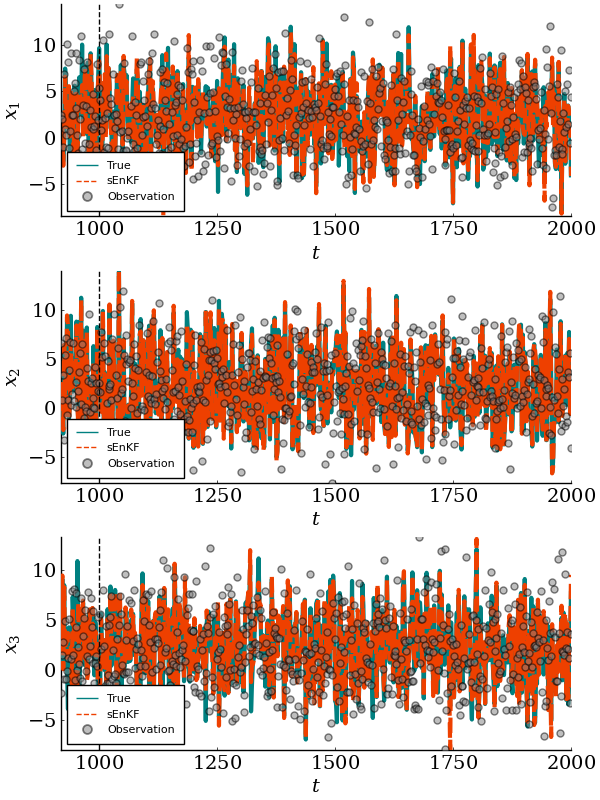

In [29]:
nb = Tspin-200
ne = Tspin+Tsmf
Δ = 5
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = :bottomleft, label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xenkf)[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
    vline!(plt[i,1], [tspin], color = :grey2, linestyle = :dash, label = "")
end

plt

Initialize the ensemble matrix for the radial stochastic map filter

In [30]:
Xspin = vcat(zeros(Ny, Ne), deepcopy(Xenkf[Tspin+1]));

Initialize the structure of the map

In [31]:
p = 2
Lrad = 3
nonid_rad = 9

# parameters of the radial map
γ = 2.0
λ = 0.01
δ = 1e-8
κ = 4.0
β = 1.0

dist = Float64.(metric_lorenz(Nx))
order = setup_order(Nx, p, 0, p, Lrad, nonid_rad, dist)

# Define index of the measurement
idx = vcat(collect(1:Ny)',collect(2:2:Nx)')

smf = SparseRadialSMF(x->x, F.h, β, ϵy, order, γ, λ, δ, κ, 
                      Ny, Nx, Ne, 
                      Δtdyn, Δtobs, 
                      dist, idx; islocalized = true);

In [23]:
Xsmf = seqassim(F, data, Tsmf, model.ϵx, smf, deepcopy(Xspin), model.Ny, model.Nx, tspin);

Progress: 100%|█████████████████████████████████████████| Time: 0:19:16


In [24]:
rmse_smf = mean(map(i->norm(data.xt[:,Tspin+i]-mean(Xsmf[i+1]; dims = 2))/sqrt(Nx), 1:Tsmf))

┌ Error: Failed to revise /media/mat/HDD/AdaptiveTransportMap/src/radialmap/optimize.jl
│   exception = (LoadError("/media/mat/HDD/AdaptiveTransportMap/src/radialmap/optimize.jl", 9, "space before \"(\" not allowed in \"fast_mul(ψ_diag::Array{Float64, 2}, Q, N::Int64, nx::Int64) (\" at /media/mat/HDD/AdaptiveTransportMap/src/radialmap/optimize.jl:9"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007fe732dcdf83])
└ @ Revise /home/mat/.julia/packages/Revise/AIcio/src/packagedef.jl:709
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   /media/mat/HDD/AdaptiveTransportMap/src/radialmap/optimize.jl
│ 
│ If the error was due to evaluation order, it can sometimes be resolved by calling `Revise.retry()`.
│ Use Revise.errors() to report errors again. Only the first error in each file is shown.
│ Your prompt color may be yellow until the errors are resolved.
└ @ Revise /home/mat/.julia/packages/Revise/AIcio/src/packagedef.jl:805


0.7886625601755554

In [25]:
(rmse_enkf-rmse_smf)/rmse_enkf

0.1561459737320707

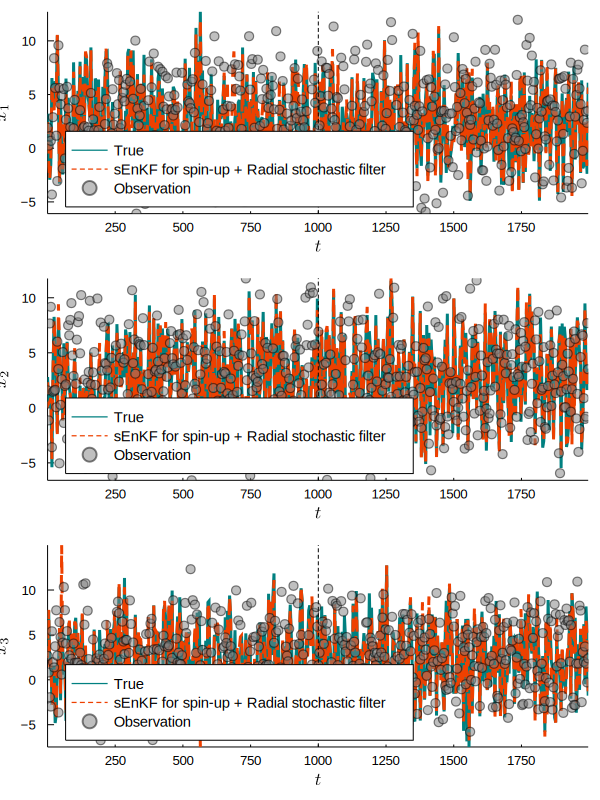

In [26]:
nb = 1
ne = Tspin+Tsmf
Δ = 10
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = :bottomleft, label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(vcat(Xenkf[1:Tspin+1], Xsmf[2:end]))[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF for spin-up + Radial stochastic filter")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
    vline!(plt[i,1], [tspin], color = :grey2, linestyle = :dash, label = "")
end

plt